In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import time

torch.manual_seed(0)

In [2]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # For Mac M1 chip GPU

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
train_data = torchvision.datasets.CIFAR10(
    root = '../datasets',
    train = True,
    download = True,
    transform = transform
)
test_data = torchvision.datasets.CIFAR10(
    root = '../datasets',
    train = False,
    download = True,
    transform = transform
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
len(train_data)

50000

In [6]:
num_epochs = 20
step = 11
batch_size = 512 # DON'T KEEP BATCH SIZE TOO SMALL! Loss will not converge at all
learning_rate = 1e-3

In [7]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_data, 
    batch_size = batch_size, 
    shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_data, 
    batch_size = batch_size, 
    shuffle = True
)

In [8]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Transpose along the axes (1,2,0)
    plt.show()

In [10]:
print('Total training images: ',len(train_data))
print('Total training batches: ',len(train_loader))

Total training images:  50000
Total training batches:  98


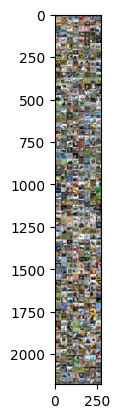

deer
cat
truck
plane
car
horse
bird
plane
horse
horse
dog
truck
frog
truck
truck
dog
deer
bird
horse
dog
frog
deer
cat
truck
bird
ship
deer
truck
car
cat
horse
cat
truck
plane
cat
ship
truck
dog
horse
cat
bird
dog
bird
plane
truck
cat
bird
bird
ship
car
plane
plane
dog
bird
bird
frog
car
plane
bird
ship
horse
horse
bird
cat
car
horse
plane
horse
horse
dog
truck
car
dog
dog
frog
frog
cat
cat
frog
car
bird
horse
car
horse
horse
frog
ship
deer
horse
truck
plane
ship
horse
deer
frog
deer
plane
frog
ship
car
truck
frog
dog
car
ship
frog
horse
dog
bird
dog
ship
truck
truck
deer
horse
dog
truck
truck
bird
dog
bird
dog
bird
deer
horse
ship
deer
cat
ship
plane
cat
frog
car
horse
truck
ship
dog
dog
cat
deer
car
plane
plane
plane
frog
ship
plane
dog
cat
plane
truck
horse
ship
bird
horse
car
car
ship
plane
truck
car
deer
dog
dog
cat
ship
dog
horse
car
ship
cat
car
truck
dog
ship
ship
dog
frog
car
car
frog
ship
car
cat
horse
truck
cat
horse
frog
deer
frog
dog
plane
car
plane
cat
truck
bird
deer
bir

In [11]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
for i in labels:
    print(classes[int(i)])

In [12]:
images.shape # (batch_size, channel_size, image_height, image_breadth)
# batch_size = 4
# channel_size = 3 (RGB)
# image height and breadth = 32 (Square image)
# Each image shape is (3,32,32) - Colour image

torch.Size([512, 3, 32, 32])

In [13]:
torchvision.utils.make_grid(images)[0].shape 
# 32 * batch_size = 32 * 4 = 128,
# Padded by 2 between batches for border => 2 + 128 + 2 + 128 + 2 + 128 + 2 + 128 + 2 = 138
# Padding in columns as well 2 + 32 + 2 = 26

torch.Size([2178, 274])

In [14]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(
                in_channels = 3, 
                out_channels = 4,
                kernel_size = 5,
                stride = 1, 
                padding = 'same'
            ),
            nn.ReLU(),
            nn.BatchNorm2d(4),
            nn.Conv2d(
                in_channels = 4, 
                out_channels = 8,
                kernel_size = 5,
                stride = 1, 
                padding = 'same'
            ), # 8, 32, 32
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2), # 8, 32, 32 --> 8, 16, 16
            nn.Dropout(0.2),
            nn.Conv2d(
                in_channels = 8,
                out_channels = 16,
                kernel_size = 3,
                padding = 'same'
            ), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = 3,
                padding = 'same'
            ), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2), # 32, 16, 16 --> 32, 8, 8
            nn.Dropout2d(0.3),
            nn.Conv2d(
                in_channels = 32,
                out_channels = 64,
                kernel_size=3,
                padding = 'same'
            ),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(
                in_channels = 64,
                out_channels = 128,
                kernel_size=3,
                padding = 'same'
            ), # 64, 8, 8 --> 128, 8, 8
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2), # 128, 8, 8 --> 128, 4, 4
            nn.Dropout2d(0.4),

            nn.Flatten(),
            nn.Linear(128*4*4, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 80),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(80,10)
        )
    
    def forward(self,x):
        return(self.convnet(x))

In [15]:
# class ConvNet(nn.Module):
#     def __init__(self):
#         super().__init__() #3,32,32
#         self.conv1 = nn.Conv2d(3,8,5,1,'same') #8,32,32
#         self.maxpool1 = nn.MaxPool2d(4,4) #8,8,8
#         self.conv2 = nn.Conv2d(8,32,3,1,'same') #32,8,8
#         self.maxpool2 = nn.MaxPool2d(2,2) #32,4,4
#         self.FC1 = nn.Linear(32*4*4,100)
#         self.FC2 = nn.Linear(100,10)
#     def forward(self,x):
#         x = torch.relu(self.conv1(x))
#         x = self.maxpool1(x)
#         x = torch.relu(self.conv2(x))
#         x = self.maxpool2(x)
#         x = torch.flatten(x, start_dim=1)
#         x = torch.relu(self.FC1(x))
#         x = self.FC2(x)
#         return(x)

In [21]:
model = ConvNet().to(device=device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = step, gamma = 0.5)

In [18]:
from torchsummary import summary
summary(model.to('cpu'), (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 32, 32]             304
              ReLU-2            [-1, 4, 32, 32]               0
       BatchNorm2d-3            [-1, 4, 32, 32]               8
            Conv2d-4            [-1, 8, 32, 32]             808
              ReLU-5            [-1, 8, 32, 32]               0
       BatchNorm2d-6            [-1, 8, 32, 32]              16
         MaxPool2d-7            [-1, 8, 16, 16]               0
           Dropout-8            [-1, 8, 16, 16]               0
            Conv2d-9           [-1, 16, 16, 16]           1,168
             ReLU-10           [-1, 16, 16, 16]               0
      BatchNorm2d-11           [-1, 16, 16, 16]              32
           Conv2d-12           [-1, 32, 16, 16]           4,640
             ReLU-13           [-1, 32, 16, 16]               0
      BatchNorm2d-14           [-1, 32,

In [19]:
n_total_steps = len(train_loader)

In [22]:
# tic = time.time()
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        params = model.state_dict()
        for param in params:
            params[param] = params[param]+0.001

        model.load_state_dict(params)
        preds = model.forward(images)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        params = model.state_dict()
        for param in params:
            params[param] = params[param]-0.001

        model.load_state_dict(params)
    scheduler.step() # Decaying learning rate per 25 epochs by 0.2 times
    print(f'Epoch {epoch+1}/{num_epochs}; Loss = {loss.item():.4f}; LR = {scheduler.get_last_lr()}')
# toc = time.time()
# print(toc-tic)

Epoch 1/20; Loss = 2.3385; LR = [0.001]
Epoch 2/20; Loss = 2.3510; LR = [0.001]
Epoch 3/20; Loss = 2.3518; LR = [0.001]
Epoch 4/20; Loss = 2.3693; LR = [0.001]
Epoch 5/20; Loss = 2.3436; LR = [0.001]
Epoch 6/20; Loss = 2.3523; LR = [0.001]
Epoch 7/20; Loss = 2.3496; LR = [0.001]
Epoch 8/20; Loss = 2.3337; LR = [0.001]
Epoch 9/20; Loss = 2.3447; LR = [0.001]
Epoch 10/20; Loss = 2.3553; LR = [0.001]
Epoch 11/20; Loss = 2.3606; LR = [0.0005]
Epoch 12/20; Loss = 2.3547; LR = [0.0005]
Epoch 13/20; Loss = 2.3452; LR = [0.0005]
Epoch 14/20; Loss = 2.3590; LR = [0.0005]
Epoch 15/20; Loss = 2.3069; LR = [0.0005]
Epoch 16/20; Loss = 2.3252; LR = [0.0005]
Epoch 17/20; Loss = 2.3648; LR = [0.0005]
Epoch 18/20; Loss = 2.3599; LR = [0.0005]
Epoch 19/20; Loss = 2.3466; LR = [0.0005]
Epoch 20/20; Loss = 2.3440; LR = [0.0005]


In [23]:
# Testing the training data
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc:.2f} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 9.11 %
Accuracy of plane: 4.74 %
Accuracy of car: 2.28 %
Accuracy of bird: 1.88 %
Accuracy of cat: 23.96 %
Accuracy of deer: 0.18 %
Accuracy of dog: 5.08 %
Accuracy of frog: 5.2 %
Accuracy of horse: 4.06 %
Accuracy of ship: 18.72 %
Accuracy of truck: 25.0 %


In [24]:
# Testing data 
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 8.92 %
Accuracy of plane: 5.3 %
Accuracy of car: 1.5 %
Accuracy of bird: 2.1 %
Accuracy of cat: 23.4 %
Accuracy of deer: 0.3 %
Accuracy of dog: 5.6 %
Accuracy of frog: 5.2 %
Accuracy of horse: 3.9 %
Accuracy of ship: 15.8 %
Accuracy of truck: 26.1 %


In [25]:
torch.save(model,'models/conv_net_noise_gradients_cifar10.pt')

# Why `model.eval()`
- If we don't do this, the mode will not switch to evaluation mode, hence will perform poorer
- By default - `model.train()` is `True`
- For example:
    - `nn.Dropout`, `nn.Dropout2d` etc., will have to be deactivated for evaluation
    - Similarly, there are some changes in operations for `nn.BatchNorm1d`, `nn.BatchNorm2d` etc., 
    and so on for other normalization algortihms

In [26]:
model1 = torch.load('models/conv_net_cifar10.pt')
model1.eval() 

ConvNet(
  (convnet): Sequential(
    (0): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (12): ReLU()
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout2d(p=0.3, inplace=False)
    (16

In [27]:
# Testing data 
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model1(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

In [ ]:
# Testing the training data
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model1(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1) # 1 here is the number of dimensions to REDUCE by
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc:.2f} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 99.93 %
Accuracy of plane: 99.84 %
Accuracy of car: 99.92 %
Accuracy of bird: 99.74 %
Accuracy of cat: 99.94 %
Accuracy of deer: 100.0 %
Accuracy of dog: 99.86 %
Accuracy of frog: 100.0 %
Accuracy of horse: 100.0 %
Accuracy of ship: 99.98 %
Accuracy of truck: 99.98 %


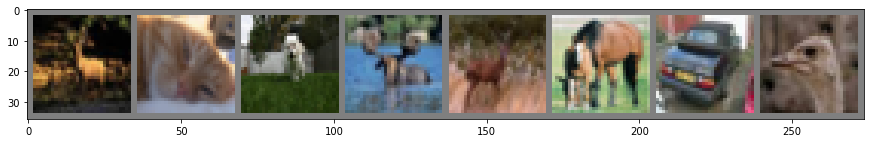

Predictions - 
deer
cat
dog
deer
deer
horse
car
bird


In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
plt.figure(figsize=[15,5])
imshow(torchvision.utils.make_grid(images[:8]))
output = model1(images[:8])
_, predicted = torch.max(output, 1)
print('Predictions - ')
for i in predicted:
    print(classes[i])